In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
from linear_mcmc import *

from redTools import *
from Kcorrect import *
from calibTools import *

In [2]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax
####################################### Plotting Function
def set_label(ax, xpcent, ypcent, text, fontsize=12, color='k'):
    
    Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
    x2 = xpcent/100.
    x1 = 1.-x2
    y2 = ypcent/100.
    y1 = 1.-y2
    x0 = x1*Xlm[0]+x2*Xlm[1]
    y0 = y1*Ylm[0]+y2*Ylm[1]
    ax.text(x0,y0, text, fontsize=fontsize, color=color)



In [3]:
def getMagLim(slope, zp, Mi_lim = -17, band = 'i'):
    
    if band=='u':
        alpha = 2.68
        beta = 1.58
        w_ = (zp-beta-Mi_lim)/(alpha-slope)
        Mlim = slope * w_ + zp
        return Mlim
    elif band=='g':
        alpha = 0.84
        beta = 0.64
        w_ = (zp-beta-Mi_lim)/(alpha-slope)
        Mlim = slope * w_ + zp
        return Mlim
    elif band=='r':
        alpha = 0.27
        beta = 0.23
        w_ = (zp-beta-Mi_lim)/(alpha-slope)
        Mlim = slope * w_ + zp
        return Mlim
    elif band=='i':
        Mlim = Mi_lim
        return Mlim
    elif band=='z':
        alpha = 0.25
        beta = 0.12
        w_ = (zp+beta-Mi_lim)/(-alpha-slope)
        Mlim = slope * w_ + zp
        return Mlim    
    elif band=='w1':
        alpha = 1.18
        beta = -0.47
        w_ = (zp+beta-Mi_lim)/(-alpha-slope)
        Mlim = slope * w_ + zp
        return Mlim  
    elif band=='w2':
        alpha = 1.32
        beta = -1.04
        w_ = (zp+beta-Mi_lim)/(-alpha-slope)
        Mlim = slope * w_ + zp
        return Mlim      

In [4]:
A = 5.450997110702376
rms_a, rms_b, rms_c =  -0.0277935,  -1.01618513, -8.68936204

band = 'i'
param = 'a'
## Luminosity function parameters
alpha = -1
Ms = -22

## TF realtion parameters
slope = -8.34
zp = -20.80-0.04
rms = 0.49

Mlim = -17
print band
print "Mag. Limit:", '%.2f'%Mlim

i
Mag. Limit: -17.00


In [5]:
####################################
def CurveFUN(x, A):

    logW0 = 2.5

    if band in ['w1', 'w2']:
        logW0=2.4
    else:
        logW0=2.5

    logW = x

    X0 = logW0 - 2.5
    X = logW-2.5

    B = -2.*A*X0

    M = slope*X+zp-0.04
    delta = ((A*X**2+B*X) - (A*X0**2+B*X0))

    try:
        delta[np.where(logW<logW0)] = 0
    except:
        if logW<logW0:
            delta = 0

    return M+delta
####################################

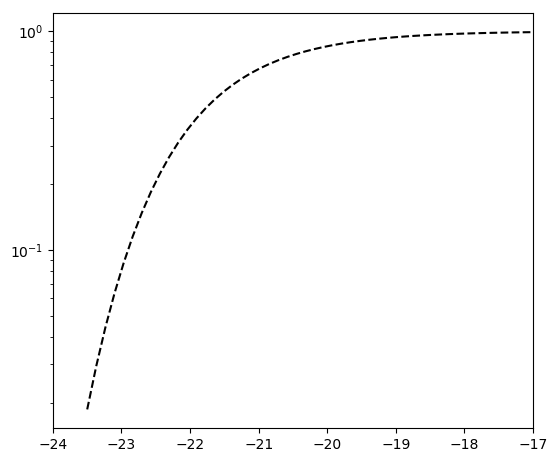

In [6]:
fig = py.figure(figsize=(6,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.15, right=0.95)
ax = fig.add_subplot(111)
ax.set_xlim([-24,-17])

M = np.linspace(-23.5,-17,50)
N = LFfunction(M, Ms, alpha)
ax.plot(M,N,'k--')

ax.set_yscale("log", nonposy='clip')

0.48810635216622034


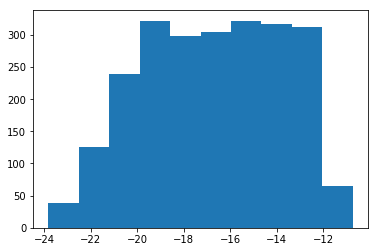

In [7]:
np.random.seed(0)

size = 3000
randMGAG = np.random.uniform(low=-24, high=-12, size=size)

randU = np.random.uniform(low=0, high=1, size=size)

randLfunct = LFfunction(randMGAG, Ms, alpha)

indx, = np.where(randU<randLfunct)

simulMag  = randMGAG[indx]
simulWimx = (simulMag-zp)/slope + 2.5
N = len(simulMag)
scatterMAG = np.random.normal(0, rms, N)
simulMag += scatterMAG


# print randMGAG
# print randU
plt.hist(simulMag)
print np.std(scatterMAG)

0.5546978553478056


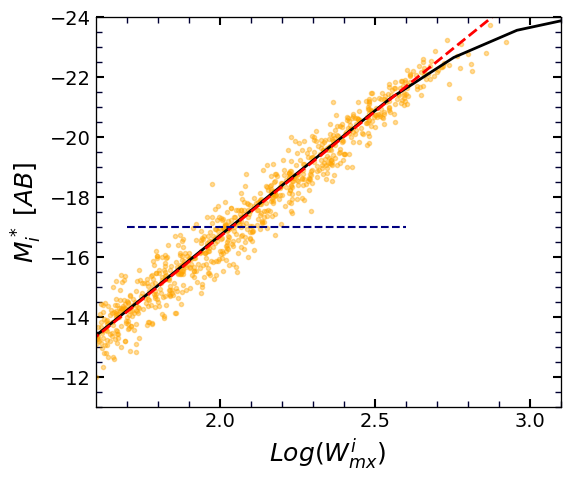

In [8]:
def myCurve(x, a, b, c):
    
    x0 = -b/2./a
    y = a*x**2+b*x+c
    
    indx, = np.where(x>=x0)
    y[indx] = a*x0**2+b*x0+c
    
    indx, = np.where(x<-21)
    x0 = -21.
    y[indx] = a*x0**2+b*x0+c
    
    return y

########################################################
def curveSimul(A, Ms, alpha, mag_scatter=True, size=100000, seed=0):
    
    
    if band in ['w1', 'w2']:
        logW0=2.4
    else:
        logW0=2.5

    logW = x
    X0 = logW0 - 2.5
    X = logW-2.5
    B = -2.*A*X0
    M = slope*X+zp-0.04
    M0 = slope*X0+zp-0.04
    
    delta = ((A*X**2+B*X) - (A*X0**2+B*X0))
    
    A0 = A
    B0 = B+slope
    C0 = zp - (A*X0**2+B*X0)
    
    np.random.seed(seed)
    
    randMGAG = np.random.uniform(low=-28, high=-12, size=size*10)
    randU = np.random.uniform(low=0, high=1, size=size*10)
    randLfunct = LFfunction(randMGAG, Ms, alpha)
    indx, = np.where(randU<randLfunct)
    simulMag  = randMGAG[indx]
    simulWimx1 = (simulMag-zp)/slope+2.5
    
    simulWimx2 = np.array([np.min(np.roots([A0, B0, C0-Msim])+2.5) for Msim in simulMag])
    
    simulWimx = simulWimx1*0.
    for i, Msim in enumerate(simulMag):
        if Msim<M0:
            simulWimx[i] = simulWimx2[i]
        else:
            simulWimx[i] = simulWimx1[i]
    
#     
    
    real_mag  = simulMag[:size]
    simulWimx = simulWimx[:size]
    
    
    ## scattring along the magnitude axis
    N = len(real_mag)
    
    rms_mag = myCurve(real_mag, rms_a, rms_b, rms_c)
    
    if mag_scatter:
        for i in range(len(real_mag)):
            real_mag[i] += np.random.normal(0, rms_mag[i])
    simulMag = real_mag
    
    return simulMag, simulWimx
    
########################################################

fig, ax = makeFig(band=band, xLim = (1.6,3.1), yLim = (-11,-24), MAGabs=True)
dye = {"u":"blue","g":"green","r":"red","i":"orange","z":"maroon","w1":"purple", 'w2': "brown"}

x = np.linspace(-5,5,50)
y = CurveFUN(x, A)
yl = slope*(x-2.5)+zp 
    
simulMag, simulWimx = curveSimul(A, Ms, alpha, 
               mag_scatter=True, size=1000, seed=0)
ax.plot(simulWimx, simulMag, '.', color=dye[band], alpha=0.4)
print np.std(simulMag-(slope*(simulWimx-2.5)+zp))


ax.plot(x,y, 'k-', lw=2) 
ax.plot(x,yl, 'r--', lw=2) 

x = np.linspace(1.7,2.6,20)
ax.plot(x,-17+(0*(x-2.5)+0),'--', lw=1.5, color='navy')      


In [9]:
def simulClusterOBS(Mlim_lst, slope, zp, 
                        simulMag, simulWimx):
    
    
    delta_lst = Mlim_lst*0.    
    
    for i, Mlim in enumerate(Mlim_lst):   
        
        indx, = np.where(simulMag<Mlim)
        
        
        simulMag_obs = simulMag[indx]
        simulWimx_obs = simulWimx[indx]
        simulMag_real =  slope*(simulWimx_obs-2.5)+zp
      
        # real mag - observed mag
        bias = simulMag_real-simulMag_obs 
          
        delta_lst[i] = np.mean(bias)
    

    return delta_lst

#########################################################



n_simul = 100
M0_C = np.arange(Mlim,Mlim-5.5,-0.5)


#########################################################


n_mag = len(M0_C)
outputs = np.zeros(n_mag*n_simul)
outputs = outputs.reshape(n_simul, n_mag)
for i in range(n_simul):
    simulMag, simulWimx = curveSimul(A, Ms, alpha, 
               mag_scatter=True, size=10000, seed=i)
    outputs[i] = simulClusterOBS(M0_C, slope, zp, simulMag, simulWimx)
    
    if i%20==0:
        print i

    
bias_CM = np.median(outputs, 0)
bias_err_CM = np.std(outputs, 0)





/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:51: ComplexWarning: Casting complex values to real discards the imaginary part


0
20
40
60
80


In [10]:
def add2Dict(myDict, code, band, param, DM):
    
    if not code in myDict:
        myDict[code]={}
    if not band in myDict[code]:
        myDict[code][band]={}
    if not param in myDict[code][band]:
        myDict[code][band][param]={}
    myDict[code][band][param] = DM
##############################################   
table   = np.genfromtxt('cluster_code_Mlimit_revised.csv' , delimiter=',', 
                        filling_values=0, names=True, dtype=None, encoding=None)

mag_lims = table[band]
code = table['Code']  
##############################################
table   = np.genfromtxt('cluster_DM_code.csv' , delimiter=',', 
                        filling_values=0, names=True, dtype=None, encoding=None)
DM_band = table['band']
DM_param = table['param']
DM_code = table['Code']
DM = table['DM']
##############################################
    
DM_Dict = {}    
for i, myCode in enumerate(DM_code):
    add2Dict(DM_Dict, myCode.strip(), DM_band[i].strip(), DM_param[i].strip(), np.float(DM[i]))  

In [11]:
for i, cc in enumerate(code):
    cc = cc.strip()
    if mag_lims[i]>0:
        if param in DM_Dict[cc][band]:
            limit_modulus = mag_lims[i]-DM_Dict[cc][band][param]
            print cc, '%.2f'%limit_modulus

V -17.08
U -17.23
Pe -17.40
A26 -18.16
N41 -17.57
N5 -18.25
Ca -19.39
N8 -18.59
N7 -19.76
A1 -18.02
Co -17.77
A4 -19.12
N40 -18.77
A2 -19.21
He -19.03


0.37$\pm$0.02 & 1.26$\pm$0.14 & -0.28$\pm$0.25 & 0.11$\pm$0.12 & 
[ 0.00365145  0.0126347  -0.0028016   0.00108302]
V -17.08 13.79 30.87
U -17.23 14.05 31.28
Pe -17.40 15.84 33.24
A26 -18.16 15.37 33.53
N41 -17.57 16.42 33.99
N5 -18.25 15.65 33.9
Ca -19.39 14.75 34.14
N8 -18.59 15.94 34.53
N7 -19.76 14.8 34.56
A1 -18.02 16.74 34.76
Co -17.77 17.02 34.79
A4 -19.12 15.72 34.84
N40 -18.77 16.34 35.11
A2 -19.21 16.05 35.26
He -19.03 16.89 35.92


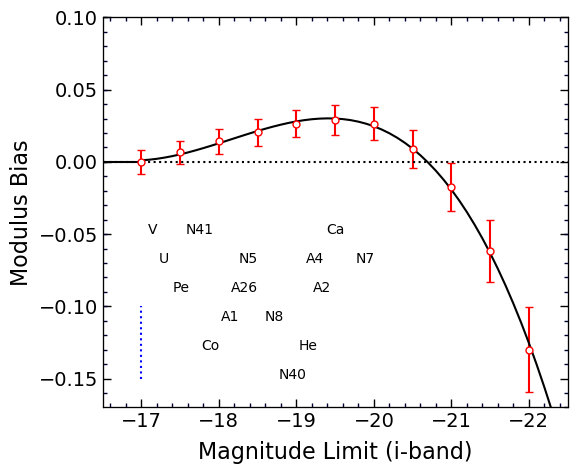

In [14]:
# def biasFuc2(M, a, b):
#     return a*(np.abs(M-Mlim))**b

def biasFuc2(M, a, b,c, d):
    X = M-Mlim
#     X = np.abs(M-Mlim)
    return a*X**3+ b*X**2+c*X+d


fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


ax.set_xlim(-16,-23.3)
ax.plot([-12,-24],[0,0], 'k:')

ax.errorbar(M0_C , bias_CM-bias_CM[0], yerr=bias_err_CM, fmt='o', color='red', capsize=3, 
            markersize=5, markerfacecolor='white')



fit, cov = curve_fit(biasFuc2, M0_C , bias_CM-bias_CM[0], sigma=bias_err_CM)
# print fit
# print cov
st = ''
for i, ff in enumerate(fit):
    st += '%.2f'%(ff*100) + '$\pm$' + '%.2f'%(np.sqrt(cov[i][i])*100) + ' & '
print st
print fit

m = np.arange(M0_C[0],-22.3,-0.1)
ax.plot(m, biasFuc2(m, fit[0], fit[1], fit[2], fit[3]), 'k-')
ax.plot([-15.7, Mlim],[0,0], 'k-')


x_ax, y_ax = set_axes(ax, xlim=(-16.5,-22.5), ylim=(-0.17,0.1), fontsize=14)
y_ax.set_yticks(np.arange(-0.15, 0.15, step=0.05))
x_ax.set_xlim(-16.5,-22.5)
# x_ax.set_xticks(np.arange(30,38, 1))
# x_ax.set_xticklabels(np.arange(30,38, 1))
x_ax.tick_params(labelsize=14)

ax.set_xlabel('Magnitude Limit', fontsize=16)
ax.set_ylabel('Modulus Bias', fontsize=16)
band_label = band
if band=='w1' or band=='w2':
    band_label = band.upper()
ax.set_xlabel('Magnitude Limit ('+band_label+'-band)', fontsize=16, labelpad=7)


Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.9*Xlm[0]+0.1*Xlm[1]
y0 = 0.1*Ylm[0]+0.9*Ylm[1]
# ax.text(x0,y0, r"$\rho = $"+"%.3f" % fit[0]+'$\pm$'+"%.3f" % np.sqrt(cov[0][0]), fontsize=14, color='k')
# y0 = 0.2*Ylm[0]+0.8*Ylm[1]
# ax.text(x0,y0, r"$\gamma = $"+"%.2f" % fit[1]+'$\pm$'+"%.2f" % np.sqrt(cov[1][1]), fontsize=14, color='k')

ax.plot([Mlim,Mlim], [-0.15,-0.1], 'b:')
ax.plot([Mlim,Mlim], [0.3,1], 'b:')

pos = {}
pos['V'] = -0.02
pos['U'] = -0.04
pos['A26'] = -0.06
pos['Ca'] = -0.02
pos['Pe'] = -0.06
pos['N5'] = -0.04
pos['A4'] = -0.04
pos['N7'] = -0.04
pos['N41'] = -0.02
pos['N8'] = -0.08
pos['A2'] = -0.06
pos['A1'] = -0.08
pos['Co'] = -0.10
pos['N40'] = -0.12
pos['He'] = -0.10
pos['F'] = -0.02

for i, cc in enumerate(code):
    cc = cc.strip()
    if mag_lims[i]>0:
        if param in DM_Dict[cc][band]:
            limit_modulus = mag_lims[i]-DM_Dict[cc][band][param]
            print cc, '%.2f'%limit_modulus, mag_lims[i],DM_Dict[cc][band][param]
            try:
                ax.text(limit_modulus, pos[cc]-0.01-0.02, cc, fontsize=10, color='k')
            except:
                pass
            

    

0.5546978553478056
V -17.08 13.79 30.87
N7 -19.76 14.8 34.56
A1 -18.02 16.74 34.76
A4 -19.12 15.72 34.84


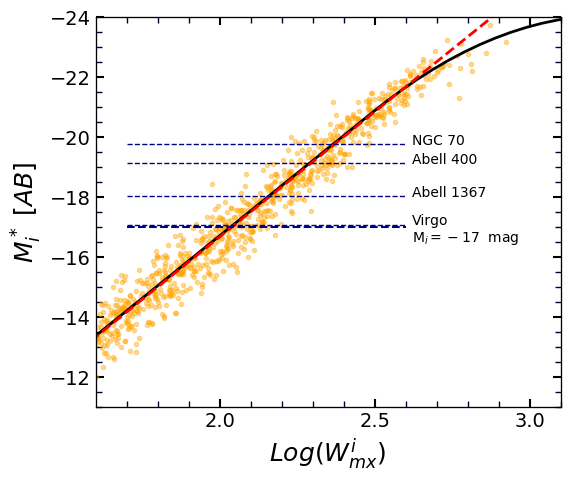

In [13]:
fig, ax = makeFig(band=band, xLim = (1.6,3.1), yLim = (-11,-24), MAGabs=True)
dye = {"u":"blue","g":"green","r":"red","i":"orange","z":"maroon","w1":"purple", 'w2': "brown"}



x = np.linspace(-5,5,200)
y = CurveFUN(x, A)
yl = slope*(x-2.5)+zp 
 
    
simulMag, simulWimx = curveSimul(A, Ms, alpha, 
               mag_scatter=True, size=1000, seed=0)
ax.plot(simulWimx, simulMag, '.', color=dye[band], alpha=0.4)
print np.std(simulMag-(slope*(simulWimx-2.5)+zp))


ax.plot(x,y, 'k-', lw=2) 
ax.plot(x,yl, 'r--', lw=2)  

x = np.linspace(1.7,2.6,20)
if band=='u':
    ax.plot(x,-17+(2.68*(x-2.5)+1.58),'--', lw=1.5, color='navy')  
if band=='g':
    ax.plot(x,-17+(0.84*(x-2.5)+0.64),'--', lw=1.5, color='navy')  
if band=='r':
    ax.plot(x,-17+(0.27*(x-2.5)+0.23),'--', lw=1.5, color='navy')  
if band=='i':
    ax.plot(x,-17+(0*(x-2.5)+0),'--', lw=1.5, color='navy')    
    ax.text(2.62, -16.5, 'M'+r'$_i=-17$'+'  mag', fontsize=10, color='k')
if band=='z':
    ax.plot(x,-17-(0.25*(x-2.5)+0.12),'--', lw=1.5, color='navy')          
if band=='w1':
    ax.plot(x,-16.1*x/x,'--', lw=1.5, color='k')
    ax.text(2.62, -17-(1.18*(2.55-2.5)-0.47)+0.9, 'M'+r'$_{W1}=-16.1$'+'  mag', fontsize=10, color='k')
    
if band=='w2':
    ax.plot(x,-17-(1.32*(x-2.5)-1.04),'--', lw=1.5, color='navy') 
    
    
    
for i, cc in enumerate(code):
    cc = cc.strip()
    if cc in ['V', 'A4', 'N7', 'A1']:
        if mag_lims[i]>0:
            if param in DM_Dict[cc][band]:
                limit_modulus = mag_lims[i]-DM_Dict[cc][band][param]
                print cc, '%.2f'%limit_modulus, mag_lims[i],DM_Dict[cc][band][param]
#                 ax.plot(x,limit_modulus-(1.18*(x-2.5)-0.47),'--', lw=1.0, color='navy')
                ax.plot(x,limit_modulus*x/x,'--', lw=1.0, color='navy')

                
                if cc=='V':
                    ax.text(2.62, limit_modulus, 'Virgo', fontsize=10, color='k')
                elif cc=='A4':
                    ax.text(2.62, limit_modulus, 'Abell 400', fontsize=10, color='k')
                elif cc=='N7':
                    ax.text(2.62, limit_modulus, 'NGC 70', fontsize=10, color='k')            
                elif cc=='A1':
                    ax.text(2.62, limit_modulus, 'Abell 1367', fontsize=10, color='k')           
    